In [2]:
# from google.colab import drive
# source_direc = drive.mount('/content/drive/')
# !pip install opencv-python
!pip install openpyxl

# Last Name  : Giri
# First Name : Surya
# CWID       : 10475010
# Purpose    : Final Project -Tubercolosis Classification

## Import Libraries

In [3]:
#import libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import shutil


from tensorflow.keras.applications import DenseNet121
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import GlobalAveragePooling2D , Dense
from keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.preprocessing import image
from sklearn.metrics import roc_auc_score, roc_curve
from tensorflow.compat.v1.logging import INFO, set_verbosity


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score

import glob
import random
import re

import random
from IPython.display import Image
import matplotlib.cm as cm


%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## Load metadata needed for images

In [4]:
# load metadata
df_normal = pd.read_excel('Normal.metadata.xlsx')
df_tb = pd.read_excel('Tuberculosis.metadata.xlsx')

Displaying the metadata

In [5]:
df_normal

,FILE NAME,FORMAT,SIZE,URL
0,Normal-1,PNG,512*512,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
1,Normal-2,PNG,512*512,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
2,Normal-3,PNG,512*512,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
3,Normal-4,PNG,512*512,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
4,Normal-5,PNG,512*512,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
...,...,...,...,...
3495,Normal-3496,PNG,512*512,https://www.kaggle.com/c/rsna-pneumonia-detect...
3496,Normal-3497,PNG,512*512,https://www.kaggle.com/c/rsna-pneumonia-detect...
3497,Normal-3498,PNG,512*512,https://www.kaggle.com/c/rsna-pneumonia-detect...
3498,Normal-3499,PNG,512*512,https://www.kaggle.com/c/rsna-pneumonia-detect...


In [6]:
df_tb

,FILE NAME,FORMAT,SIZE,URL
0,Tuberculosis-1,PNG,512*512,http://tuberculosis.by/
1,Tuberculosis-2,PNG,512*512,http://tuberculosis.by/
2,Tuberculosis-3,PNG,512*512,http://tuberculosis.by/
3,Tuberculosis-4,PNG,512*512,http://tuberculosis.by/
4,Tuberculosis-5,PNG,512*512,http://tuberculosis.by/
...,...,...,...,...
695,Tuberculosis-696,PNG,512*512,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
696,Tuberculosis-697,PNG,512*512,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
697,Tuberculosis-698,PNG,512*512,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...
698,Tuberculosis-699,PNG,512*512,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4...


## Data manipulation

In [7]:
# Dropping columns we don't need: format, size and URL
df_normal.drop(columns = ['FORMAT', 'SIZE', 'URL'], inplace = True)
df_tb.drop(columns = ['FORMAT', 'SIZE', 'URL'], inplace = True)

# Creating a column 'TB_Status', which will be 1 if Tubercolosis, and 0 if normal
df_tb['tb_status'], df_normal['tb_status'] = np.float(1), np.float(0)

# Renaming some columns
df_tb.rename(columns = {'FILE NAME':'Image'}, inplace = True)
df_normal.rename(columns = {'FILE NAME':'Image'}, inplace = True)

# Join the two datasets so that it is easier to work with
df_joined = pd.concat([df_normal, df_tb])

In [8]:
df_joined

,Image,tb_status
0,Normal-1,0.0
1,Normal-2,0.0
2,Normal-3,0.0
3,Normal-4,0.0
4,Normal-5,0.0
...,...,...
695,Tuberculosis-696,1.0
696,Tuberculosis-697,1.0
697,Tuberculosis-698,1.0
698,Tuberculosis-699,1.0


In [9]:
# Randomize the data and reset the index so that it starts from 0 
df = df_joined.sample(frac=1).reset_index(drop=True)

In [10]:
df

,Image,tb_status
0,Normal-1449,0.0
1,Normal-713,0.0
2,Normal-3033,0.0
3,Normal-2278,0.0
4,Normal-2702,0.0
...,...,...
4195,Tuberculosis-447,1.0
4196,Normal-3458,0.0
4197,Normal-3053,0.0
4198,Normal-2235,0.0


## Create and map directories

In [11]:
# Source image for normal
source_normal = 'C:/Users/surya/TB_Chest_Radiography_Database/Normal'

# Source images for tubercolosis
source_tb = 'C:/Users/surya/TB_Chest_Radiography_Database/Tuberculosis'


In [12]:
# For Jupyter
def create_directories(root_path):
    train_direc = 'C:/Users/surya/training'
    val_direc = 'C:/Users/surya/validation'
    test_direc = 'C:/Users/surya/testing'
    os.makedirs(train_direc + '/Normal')
    os.makedirs(train_direc + '/Tuberculosis')
    os.makedirs(val_direc + '/Normal')
    os.makedirs(val_direc + '/Tuberculosis')
    os.makedirs(test_direc + '/Normal')
    os.makedirs(test_direc + '/Tuberculosis')
    os.makedirs(root_path + '/Images')

    image_direc = 'C:/Users/surya/Images'

# create_directories('C:/Users/surya')


# Map train validation test directories
# Image directory
image_direc = "C:/Users/surya/Images"

# Training, validation and testing directory
train_direc = "C:/Users/surya/training"
val_direc = "C:/Users/surya/validation"
test_direc = "C:/Users/surya/testing"

# Making normal directory inside training, validation and testing directories
train_normal_direc = "C:/Users/surya/training/Normal"
val_normal_direc = "C:/Users/surya/validation/Normal"
test_normal_direc = "C:/Users/surya/testing/Normal"

# Making tubercolosis directory isnide training, testing and vvalidation directories
train_tb_direc = "C:/Users/surya/training/Tuberculosis"
val_tb_direc = "C:/Users/surya/validation/Tuberculosis"
test_tb_direc = "C:/Users/surya/testing/Tuberculosis"

# For Colab
# def create_directories(root_path):
#   train_direc = os.path.join('./','training')
#   val_direc = os.path.join('./', 'validation')
#   test_direc = os.path.join('./','testing')
#   os.makedirs(train_direc + '/Normal')
#   os.makedirs(train_direc + '/Tuberculosis')
#   os.makedirs(val_direc + '/Normal')
#   os.makedirs(val_direc + '/Tuberculosis')
#   os.makedirs(test_direc + '/Normal')
#   os.makedirs(test_direc + '/Tuberculosis')
#   os.makedirs('./' + '/Images')

#   image_direc = os.path.join('./', 'Images')

# # create_directories('./')


# # Map train validation test directories
# # Image directory
# image_direc = os.path.join('./', 'Images')

# # Training, validation and testing directory
# train_direc = "./training"
# val_direc = "./validation"
# test_direc = "./testing"

# # Making normal directory inside training, validation and testing directories
# train_normal_direc = os.path.join(train_direc, "Normal/")
# val_normal_direc = os.path.join(val_direc, "Normal/")
# test_normal_direc = os.path.join(test_direc, "Normal/")

# # Making tubercolosis directory isnide training, testing and vvalidation directories
# train_tb_direc = os.path.join(train_direc, "Tuberculosis/")
# val_tb_direc = os.path.join(val_direc, "Tuberculosis/")
# test_tb_direc = os.path.join(test_direc, "Tuberculosis/")


## Split data for trainning, testing and validation
Training : Validation : Testing = 80:10:10

NOTE: There is imbalance in the dataset

In [13]:
# Function for splitting data
def split_data(SOURCE, TRAINING, VAL, TESTING, SPLIT_SIZE_TRAIN = 0.8, SPLIT_SIZE_VAL = 0.1):

  use_dir = [fn for fn in os.listdir(SOURCE)]
  random.seed(2)
  train_dt = random.sample(use_dir, np.int64(SPLIT_SIZE_TRAIN * len(use_dir)))
  test_dt = [fn for fn in use_dir if fn not in train_dt]
  val_dt = random.sample(test_dt, np.int64(SPLIT_SIZE_VAL * len(use_dir)))
  test_dt = [fn for fn in test_dt if fn not in val_dt]

  # Data for training
  for fn in train_dt :
    shutil.copy(os.path.join(SOURCE, fn), TRAINING)

  # Data for validation
  for fn in val_dt :
    shutil.copy(os.path.join(SOURCE, fn), VAL)
  
  # Data for testing
  for fn in test_dt:
    shutil.copy(os.path.join(SOURCE, fn), TESTING)

# For normal
split_data(source_normal, train_normal_direc, val_normal_direc,  test_normal_direc)
# For tubercolosis
split_data(source_tb, train_tb_direc, val_tb_direc,  test_tb_direc)

Now copy the images to the source directory

In [14]:
def images_copy(SOURCE_N, SOURCE_TB, IMAGE_DIR ):
    use_dir_n = [fn for fn in os.listdir(SOURCE_N)] 
    use_dir_tb = [fn for fn in os.listdir(SOURCE_TB)] 
    random.seed(2)
    
    # Copy images to '..Source/Normal'
    for fn in use_dir_n :
        shutil.copy(os.path.join(SOURCE_N, fn), IMAGE_DIR)
    # Copy images to '..Source/Tubercolosis'
    for fn in use_dir_tb :
        shutil.copy(os.path.join(SOURCE_TB, fn), IMAGE_DIR)

images_copy(source_normal, source_tb, image_direc )

In [15]:
# Creating variables for images
def create_df(NORM_DIR, TB_DIR , df ):
    df_fn_n = os.listdir(NORM_DIR)
    df_fn_tb = os.listdir(TB_DIR)
    df_fn = df_fn_n + df_fn_tb
    df_ext = []
    for fn in df_fn:
        df_ext.append(fn[:-4])
    df_res = df[df['Image'].isin(df_ext)]
    
    return df_res
    
train_df = create_df(train_normal_direc, train_tb_direc, df)
val_df = create_df(val_normal_direc, val_tb_direc, df)
test_df = create_df(test_normal_direc, test_tb_direc, df)

In [16]:
# add .png as suffix in Filename column since our images name has .png as suffix also
train_df['Image'] = train_df['Image'] + '.png'
val_df['Image'] = val_df['Image'] + '.png'
test_df['Image'] = test_df['Image'] + '.png'

In [17]:
# Checking id the data manipulation was succesful. There should be 4200 rows
print(train_df.shape[0] + val_df.shape[0] + test_df.shape[0])

4200


In [18]:
train_df

,Image,tb_status
1,Normal-713.png,0.0
2,Normal-3033.png,0.0
3,Normal-2278.png,0.0
4,Normal-2702.png,0.0
5,Normal-2373.png,0.0
...,...,...
4195,Tuberculosis-447.png,1.0
4196,Normal-3458.png,0.0
4197,Normal-3053.png,0.0
4198,Normal-2235.png,0.0


Using Glob for file name matching

In [19]:
import glob
train_norm = glob.glob(train_normal_direc +'/*.png')
train_tb = glob.glob(train_tb_direc + '/*.png')

In [20]:
train_norm[:12]

['C:/Users/surya/training/Normal\\Normal-10.png',
 'C:/Users/surya/training/Normal\\Normal-100.png',
 'C:/Users/surya/training/Normal\\Normal-1000.png',
 'C:/Users/surya/training/Normal\\Normal-1002.png',
 'C:/Users/surya/training/Normal\\Normal-1003.png',
 'C:/Users/surya/training/Normal\\Normal-1004.png',
 'C:/Users/surya/training/Normal\\Normal-1005.png',
 'C:/Users/surya/training/Normal\\Normal-1006.png',
 'C:/Users/surya/training/Normal\\Normal-1007.png',
 'C:/Users/surya/training/Normal\\Normal-1008.png',
 'C:/Users/surya/training/Normal\\Normal-1009.png',
 'C:/Users/surya/training/Normal\\Normal-1010.png']

In [21]:
train_tb[:12]

['C:/Users/surya/training/Tuberculosis\\Tuberculosis-1.png',
 'C:/Users/surya/training/Tuberculosis\\Tuberculosis-10.png',
 'C:/Users/surya/training/Tuberculosis\\Tuberculosis-100.png',
 'C:/Users/surya/training/Tuberculosis\\Tuberculosis-102.png',
 'C:/Users/surya/training/Tuberculosis\\Tuberculosis-103.png',
 'C:/Users/surya/training/Tuberculosis\\Tuberculosis-106.png',
 'C:/Users/surya/training/Tuberculosis\\Tuberculosis-107.png',
 'C:/Users/surya/training/Tuberculosis\\Tuberculosis-108.png',
 'C:/Users/surya/training/Tuberculosis\\Tuberculosis-11.png',
 'C:/Users/surya/training/Tuberculosis\\Tuberculosis-110.png',
 'C:/Users/surya/training/Tuberculosis\\Tuberculosis-111.png',
 'C:/Users/surya/training/Tuberculosis\\Tuberculosis-112.png']

Normal


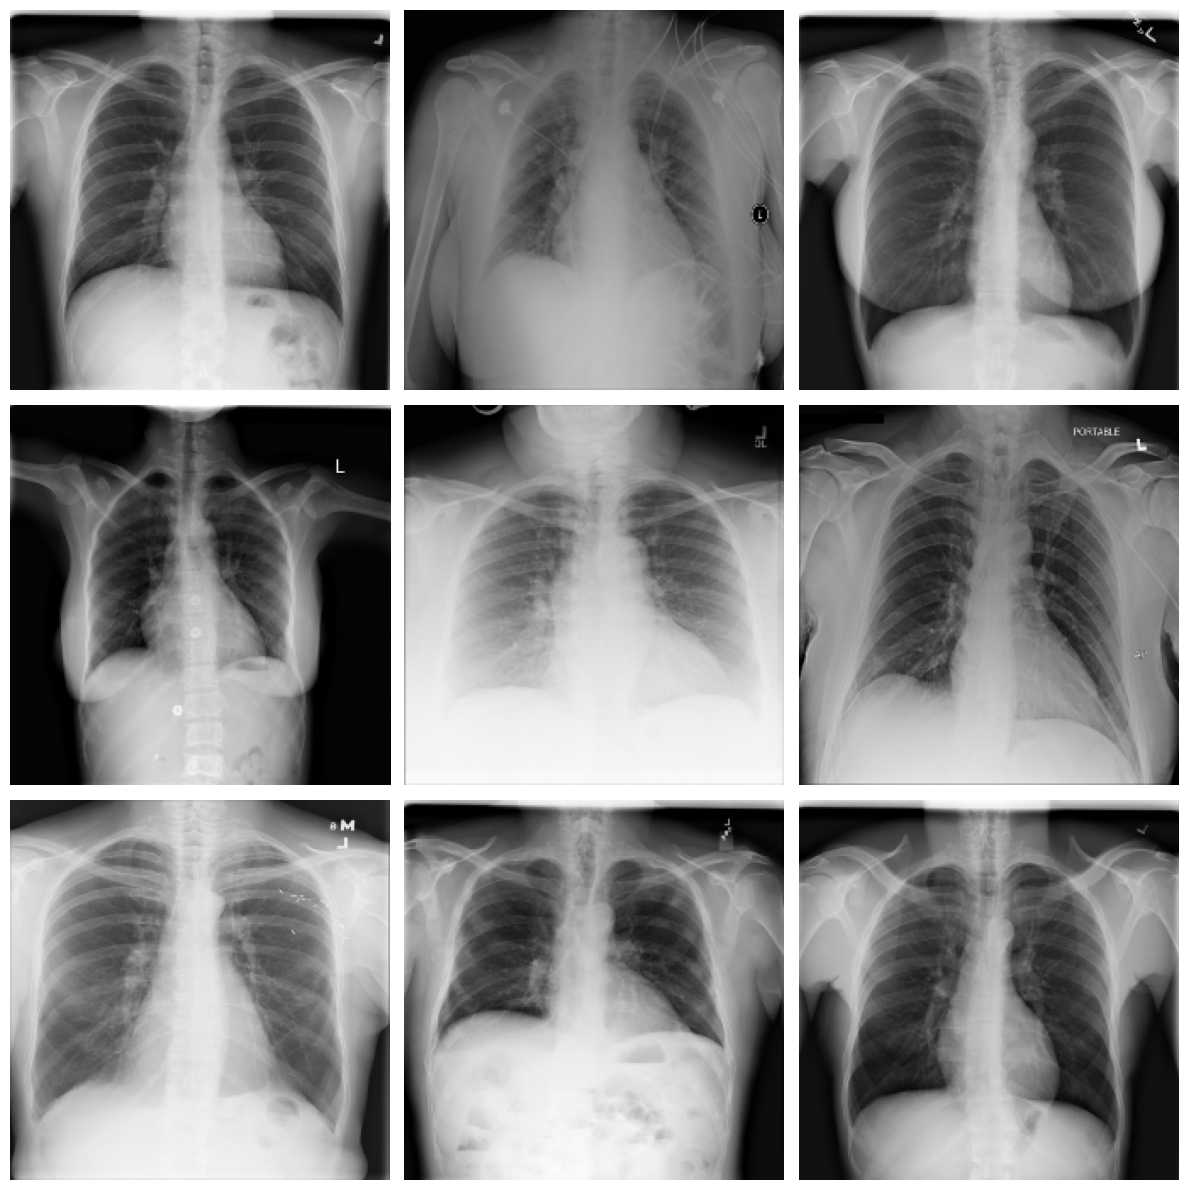

In [22]:
print('Normal')

plt.figure(figsize=(12,12))

for i in range(0, 9):
    plt.subplot(3,3,i + 1)
    img = cv2.imread(train_norm[i])
    img = cv2.resize(img, (224,224))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()

Tuberculosis


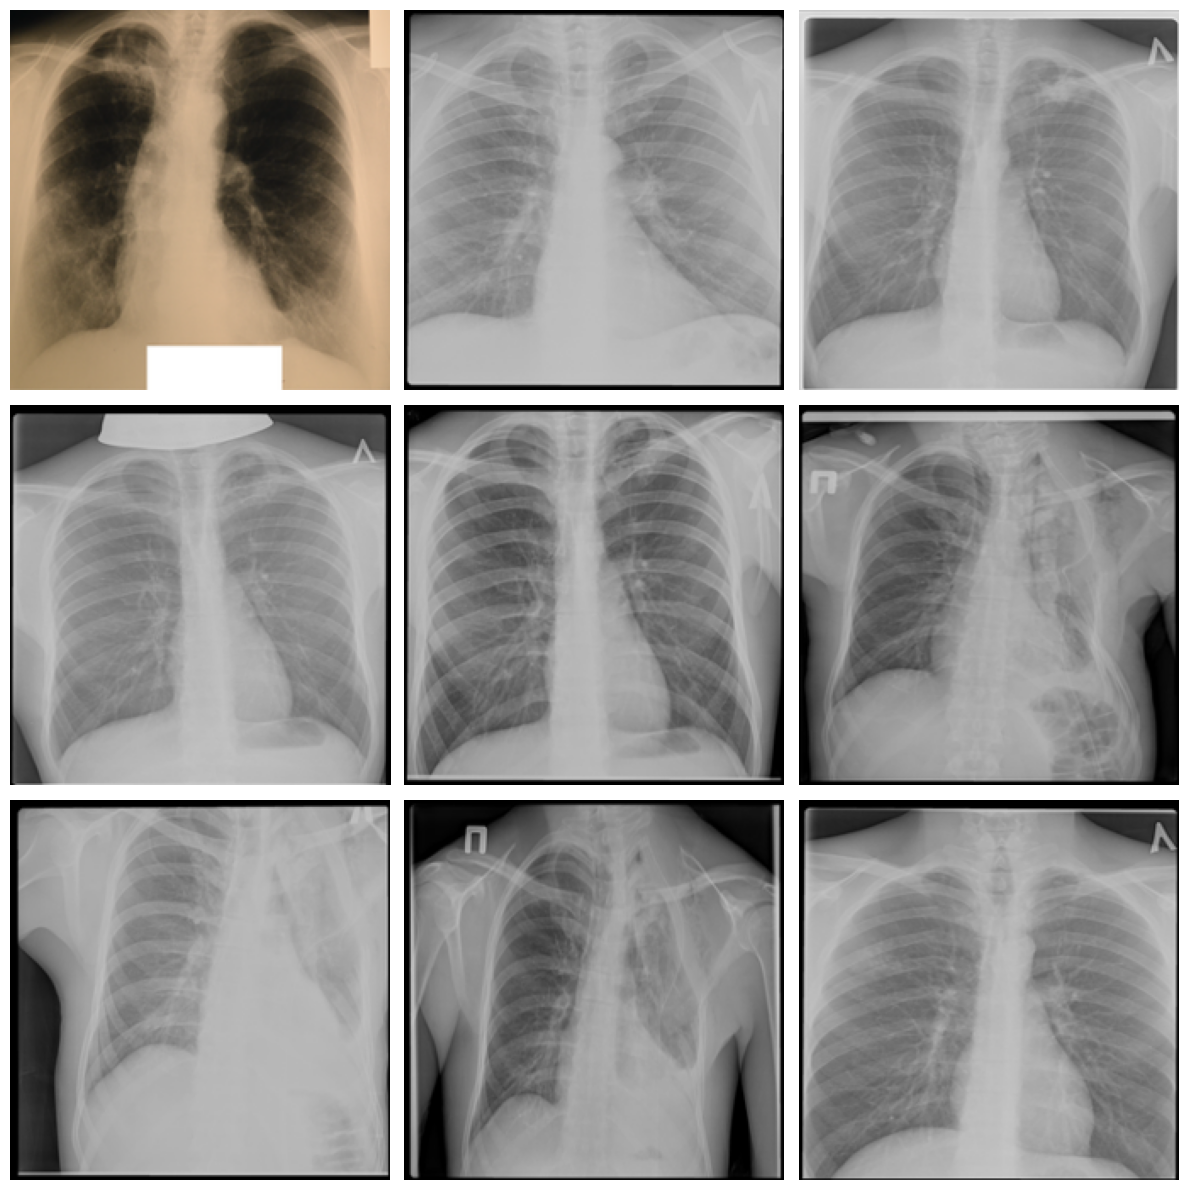

In [23]:
print('Tuberculosis')

plt.figure(figsize=(12,12))

for i in range(0, 9):
    plt.subplot(3,3,i + 1)
    img = cv2.imread(train_tb[i])
    img = cv2.resize(img, (224,224))
    plt.imshow(img)
    plt.axis("off")

plt.tight_layout()
plt.show()

## Analyzing the data

In [74]:
# os.listdir returns a list containing all files under the given path
print(f"Number of Normal Images: {len(os.listdir(source_normal))}")
print(f"Number of Tubercolosis Images: {len(os.listdir(source_tb))}")

Number of Normal Images: 3500
Number of Tubercolosis Images: 700


In [25]:
print('Percent of Tuberculosis: {} %'.format(100 * (len(os.listdir(train_tb_direc))/(len(os.listdir(train_normal_direc))+len(os.listdir(train_tb_direc))))))

Percent of Tuberculosis: 16.666666666666664 %


## Handling the imbalance using Sample Weighting in Loss function
Reference:
https://www.kaggle.com/code/sanphats/microcalcification-weighting-loss-dnn

Since the dataset is imbalanced, meaniing, there are significantly more images for normal than for tubercolosis. This will negatively affect our model if we use it as is since the contribution from tubercolosis will be less. Tubercolosis contribution is vital since it will train the model to identify tubercolosis images. Thus we'll make contributions equal by doing, i.e.:

positive weight x positive frequency  = negative weight x negative frequency

This can be done by making positive weights  = negative frequency and negative weights  = positive frequency

In [26]:
# Compute class frequencies
positive_frequency = round((len(os.listdir(train_tb_direc))/len(os.listdir(train_normal_direc))),2)
negative_frequency = 1 - positive_frequency

# Calculate weights
positive_weights = negative_frequency
negative_weights = positive_frequency
positive_contribution = positive_frequency * positive_weights 
negative_contribution = negative_frequency * negative_weights

print("Negative contribution: ", negative_contribution)
print("Positive contribution: ", positive_contribution)


Negative contribution:  0.16000000000000003
Positive contribution:  0.16000000000000003


Function for weighted loss
$$\mathcal{L}_{cross-entropy}^{w}(x) = - (w_{p} y \log(f(x)) + w_{n}(1-y) \log( 1 - f(x) ) ).$$

In [27]:
def get_weighted_loss(pos_weights, neg_weights, epsilon=1e-7):
    
    def weighted_loss(y_true, y_pred):
        # initialize loss to zero
        loss = 0.0
        
        # for each class, add average weighted loss for that class 
        loss += K.mean(-(pos_weights *y_true * K.log(y_pred + epsilon) 
                             + neg_weights* (1 - y_true) * K.log( 1 - y_pred + epsilon))) 
        return loss
    
    return weighted_loss

## Data Preprocessing
1. Some augmentations need to be applied since if images are rotated or shifted during taking x-rays, they can mean something different and give inaccurate results
2. Normalize mean and standard deviation of each data
3. We need to convert single channel x-rays to 3 channel x-rays so that there is no shape problems.
4. We finally then use the statistics learned from the training data to transform and preprocess testing and validation data 

In [28]:
# Create channel convert function

# Setting pixel size to 320x320
def preprocessed_train_function(df, image_dir, x_col, y_col, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    # x_col (str): name of column in df that holds filenames.
    # y_col (list): name of column in df that holds labels.

    # normalize each image using batch statistic
    image_data_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True,
        zoom_range = 0.1,
        rotation_range = 5,
        width_shift_range = 0.1,
        height_shift_range = 0.1)
    
    # flow from directory with specified batch size
    # and target image size
    preprocessed_train = image_data_generator.flow_from_dataframe( dataframe=df,
                                                           directory=image_dir,
                                                           x_col=x_col,
                                                           y_col=y_col,
                                                           class_mode="raw",
                                                           batch_size=batch_size,
                                                           shuffle=shuffle,
                                                           seed=seed,
                                                           target_size=(target_w,target_h))

    
    return preprocessed_train

Generate the pre-processed images for training, testing and validation

In [29]:
preprocessed_train = preprocessed_train_function(train_df, image_direc, 'Image', 'tb_status')

Found 3360 validated image filenames.


Now use the 

In [30]:
def preprocess_val_test(val_df, test_df, train_df, image_dir, x_col, y_col, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):

    # Get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe( dataframe=train_df,
                                                           directory=image_dir,
                                                           x_col= 'Image',
                                                           y_col= 'tb_status',
                                                           class_mode="raw",
                                                           batch_size=sample_size,
                                                           shuffle=True,
                                                           seed=seed,
                                                           target_size=(target_w,target_h))
    
    # Generate bacthes for data samples
    batch = raw_train_generator.next()
    # Sample data
    data_sample = batch[0]

    # Use sampled data to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)

    image_generator.fit(data_sample)

    # get val and test generator
    preprocessed_val = image_generator.flow_from_dataframe(
            dataframe=val_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_col,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    preprocessed_test = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_col,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    
    return preprocessed_val, preprocessed_test

In [31]:
preprocessed_val, preprocessed_test = preprocess_val_test(val_df, test_df, train_df, image_direc, 'Image', 'tb_status')

Found 3360 validated image filenames.
Found 420 validated image filenames.
Found 420 validated image filenames.


Displaying one of the preprocessed images from training dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


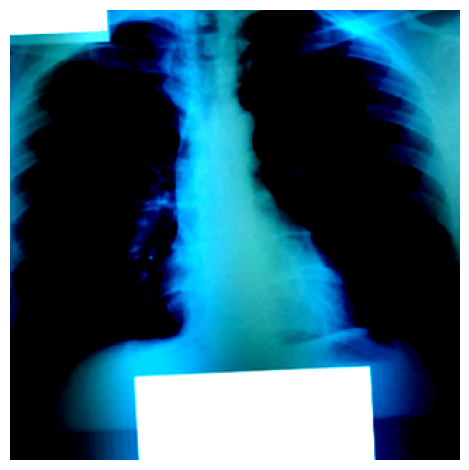

In [32]:
x, y = preprocessed_train.__getitem__(0)
plt.imshow(x[0])
plt.axis("off")
plt.tight_layout()
plt.show()

## Transfer Learning
Choosing DenseNet for this problem as DenseNet gives better performance when compared to ResNet in most cases. Reference: https://openaccess.thecvf.com/content/WACV2021/papers/Zhang_ResNet_or_DenseNet_Introducing_Dense_Shortcuts_to_ResNet_WACV_2021_paper.pdf

In [33]:
## create the base pre-trained model
densenet_model = DenseNet121(weights='imagenet', include_top=False, classes=2, input_shape=(320, 320, 3))

x = densenet_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# and a logistic layer
output = Dense(1, activation="sigmoid")(x)

model1 = Model(inputs=densenet_model.input, outputs = output)
model1.compile(optimizer= 'adam', loss=get_weighted_loss(positive_weights, negative_weights), metrics=["accuracy","AUC"])

In [34]:
# fit model
history = model1.fit_generator(preprocessed_train, 
                              validation_data=preprocessed_val,
                              steps_per_epoch=150, 
                              validation_steps=50,  
                              epochs = 20,
                              ) # callbacks = [MC]

Epoch 1/20
150/150 [==============================] - 63s 254ms/step - loss: 0.1120 - accuracy: 0.8617 - auc: 0.9265 - val_loss: 2.0424 - val_accuracy: 0.8400 - val_auc: 0.5077
Epoch 2/20
150/150 [==============================] - 33s 219ms/step - loss: 0.0864 - accuracy: 0.9050 - auc: 0.9483 - val_loss: 1.2786 - val_accuracy: 0.8600 - val_auc: 0.6751
Epoch 3/20
150/150 [==============================] - 31s 209ms/step - loss: 0.0603 - accuracy: 0.9392 - auc: 0.9756 - val_loss: 1.1298 - val_accuracy: 0.8950 - val_auc: 0.7133
Epoch 4/20
150/150 [==============================] - 31s 207ms/step - loss: 0.0972 - accuracy: 0.8808 - auc: 0.9296 - val_loss: 0.2404 - val_accuracy: 0.8825 - val_auc: 0.8344
Epoch 5/20
150/150 [==============================] - 30s 201ms/step - loss: 0.0697 - accuracy: 0.9267 - auc: 0.9615 - val_loss: 0.9672 - val_accuracy: 0.9175 - val_auc: 0.7615
Epoch 6/20
150/150 [==============================] - 30s 198ms/step - loss: 0.0521 - accuracy: 0.9383 - auc: 0.979

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Flatten
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense,Activation,Dropout
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from tensorflow.keras.applications.resnet50 import ResNet50
import cv2
import PIL.Image

In [36]:
from tensorflow.keras.applications.densenet import DenseNet169

## create the base pre-trained model
densenet_model2 = DenseNet169(weights='imagenet', include_top=False, classes=2, input_shape=(320, 320, 3))

x2 = densenet_model2.output

# add a global spatial average pooling layer
x2 = GlobalAveragePooling2D()(x2)

# and a logistic layer
output2 = Dense(1, activation="sigmoid")(x2)

model2 = Model(inputs=densenet_model2.input, outputs = output2)
model2.compile(optimizer= 'adam', loss=get_weighted_loss(positive_weights, negative_weights), metrics=["accuracy","AUC"])

In [37]:
# fit model
history2 = model2.fit_generator(preprocessed_train, 
                              validation_data=preprocessed_val,
                              steps_per_epoch=150, 
                              validation_steps= 50,  
                              epochs = 20
                              ) 

Epoch 1/20
150/150 [==============================] - 51s 231ms/step - loss: 0.1163 - accuracy: 0.8600 - auc: 0.9153 - val_loss: 1.5843 - val_accuracy: 0.8350 - val_auc: 0.5245
Epoch 2/20
150/150 [==============================] - 33s 216ms/step - loss: 0.0689 - accuracy: 0.9158 - auc: 0.9656 - val_loss: 1.4448 - val_accuracy: 0.8675 - val_auc: 0.6462
Epoch 3/20
150/150 [==============================] - 32s 215ms/step - loss: 0.0844 - accuracy: 0.9042 - auc: 0.9522 - val_loss: 0.4040 - val_accuracy: 0.7600 - val_auc: 0.8174
Epoch 4/20
150/150 [==============================] - 33s 217ms/step - loss: 0.0804 - accuracy: 0.9000 - auc: 0.9563 - val_loss: 2.5769 - val_accuracy: 0.1650 - val_auc: 0.4487
Epoch 5/20
150/150 [==============================] - 33s 221ms/step - loss: 0.0886 - accuracy: 0.8883 - auc: 0.9494 - val_loss: 1.3175 - val_accuracy: 0.8675 - val_auc: 0.6642
Epoch 6/20
150/150 [==============================] - 33s 218ms/step - loss: 0.0688 - accuracy: 0.9142 - auc: 0.963

In [38]:
# checkpoint_path = "training_1/cp.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# MC1 = ModelCheckpoint(filepath= checkpoint_path, verbose =2, save_best_only=True,save_weights_only=True )

In [39]:
# # fit
# model1.fit_generator(preprocessed_train, 
#                               validation_data=preprocessed_val,
#                               steps_per_epoch=150, 
#                               validation_steps= 50,  
#                               epochs = 20,
#                               callbacks=MC1
#                               )

In [40]:
# checkpoint_path = "training_2/cp.ckpt"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# MC2 = ModelCheckpoint(filepath= checkpoint_path, verbose =2, save_best_only=True, save_weights_only=True )

In [41]:
# # fit model
# model2.fit_generator(preprocessed_train, 
#                               validation_data=preprocessed_val,
#                               steps_per_epoch=150, 
#                               validation_steps= 50,  
#                               epochs = 20, callbacks=MC2
#                               ) 

In [42]:
resnet_model  = ResNet50(weights='imagenet', include_top=False, classes=2,
                         input_shape=(320,320,3))

for layer in resnet_model.layers:
    layer.trainable = True


In [43]:
X = resnet_model.output
X = Flatten()(X)
# add a global spatial average pooling layer
# X = GlobalAveragePooling2D()(X)

# X = Dense(512, kernel_initializer='he_uniform')(X)
# #X = Dropout(0.5)(X)
# X = BatchNormalization()(X)
# X = Activation('relu')(X)

# X = Dense(16, kernel_initializer='he_uniform')(X)
# #X = Dropout(0.5)(X)
# X = BatchNormalization()(X)
# X = Activation('relu')(X)

output3 = Dense(1, activation='sigmoid')(X)

model3 = Model(inputs=resnet_model.input, outputs=output3)

In [44]:
optimizer = Adam(lr=0.0001)
model3.compile(loss=get_weighted_loss(positive_weights, negative_weights),
              optimizer=optimizer, 
              metrics=['accuracy'])

In [45]:
n_epoch = 20

# early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
#                            mode='auto', restore_best_weights=True)

# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, 
#                               verbose=1, mode='auto')

In [47]:
model3.fit_generator(preprocessed_train, validation_data=preprocessed_val,
                     steps_per_epoch=150, validation_steps=50, epochs=n_epoch)#verbose=1, callbacks=[reduce_lr], class_weight=class_weights, shuffle=True,use_multiprocessing=True,
#workers=16,

Epoch 1/20
150/150 [==============================] - 28s 187ms/step - loss: 0.0963 - accuracy: 0.9358 - val_loss: 2.5861 - val_accuracy: 0.1625
Epoch 2/20
150/150 [==============================] - 28s 186ms/step - loss: 0.1170 - accuracy: 0.9625 - val_loss: 0.5064 - val_accuracy: 0.6050
Epoch 3/20
150/150 [==============================] - 28s 186ms/step - loss: 0.0616 - accuracy: 0.9842 - val_loss: 1.9060 - val_accuracy: 0.1625
Epoch 4/20
150/150 [==============================] - 27s 181ms/step - loss: 0.0122 - accuracy: 0.9892 - val_loss: 1.9329 - val_accuracy: 0.1625
Epoch 5/20
150/150 [==============================] - 28s 184ms/step - loss: 0.0278 - accuracy: 0.9850 - val_loss: 0.1570 - val_accuracy: 0.7925
Epoch 6/20
150/150 [==============================] - 28s 188ms/step - loss: 0.0185 - accuracy: 0.9900 - val_loss: 0.1679 - val_accuracy: 0.7100
Epoch 7/20
150/150 [==============================] - 28s 185ms/step - loss: 0.0057 - accuracy: 0.9917 - val_loss: 0.0024 - val_ac

## Evaluate model

In [48]:
# Resetting predictions for accurate results
preprocessed_test.reset()
predicted_vals1 = model1.predict_generator(preprocessed_test, steps = len(preprocessed_test))
y_pred1 = np.where(predicted_vals1 >= 0.5,1 ,0)
y_pred1 = y_pred1.flatten() 

In [49]:
# Resetting predictions for accurate results
preprocessed_test.reset()
predicted_vals2 = model2.predict_generator(preprocessed_test, steps = len(preprocessed_test))
y_pred2 = np.where(predicted_vals2 >= 0.5,1 ,0)
y_pred2 = y_pred2.flatten() 

In [50]:
# Resetting predictions for accurate results
preprocessed_test.reset()
predicted_vals3 = model3.predict_generator(preprocessed_test, steps = len(preprocessed_test))
y_pred3 = np.where(predicted_vals3 >= 0.5,1 ,0)
y_pred3 = y_pred3.flatten() 

In [51]:
y_test = test_df['tb_status']
print(classification_report(y_test, y_pred1))
print("Accuracy of the Model 1:",accuracy_score(y_test, y_pred1)*100,"%")

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98       350
         1.0       0.95      0.87      0.91        70

    accuracy                           0.97       420
   macro avg       0.96      0.93      0.95       420
weighted avg       0.97      0.97      0.97       420

Accuracy of the Model 1: 97.14285714285714 %


In [52]:
print(classification_report(y_test, y_pred2))
print("Accuracy of the Model 2:",accuracy_score(y_test, y_pred2)*100,"%")

              precision    recall  f1-score   support

         0.0       1.00      0.29      0.45       350
         1.0       0.22      1.00      0.36        70

    accuracy                           0.41       420
   macro avg       0.61      0.64      0.40       420
weighted avg       0.87      0.41      0.43       420

Accuracy of the Model 2: 40.714285714285715 %


In [53]:
print(classification_report(y_test, y_pred3))
print("Accuracy of the Model 3:",accuracy_score(y_test, y_pred3)*100,"%")

              precision    recall  f1-score   support

         0.0       0.86      1.00      0.92       350
         1.0       1.00      0.16      0.27        70

    accuracy                           0.86       420
   macro avg       0.93      0.58      0.60       420
weighted avg       0.88      0.86      0.81       420

Accuracy of the Model 3: 85.95238095238096 %


In [68]:
preprocessed_test.filenames

['Normal-2072.png',
 'Normal-1695.png',
 'Normal-377.png',
 'Normal-1896.png',
 'Normal-3227.png',
 'Normal-2894.png',
 'Tuberculosis-378.png',
 'Normal-1601.png',
 'Normal-2347.png',
 'Normal-236.png',
 'Normal-3444.png',
 'Tuberculosis-596.png',
 'Normal-3130.png',
 'Normal-3161.png',
 'Tuberculosis-624.png',
 'Normal-2538.png',
 'Normal-1039.png',
 'Normal-160.png',
 'Tuberculosis-504.png',
 'Tuberculosis-113.png',
 'Normal-2389.png',
 'Normal-1102.png',
 'Normal-2.png',
 'Tuberculosis-585.png',
 'Normal-889.png',
 'Normal-1761.png',
 'Normal-1957.png',
 'Normal-2403.png',
 'Normal-1269.png',
 'Normal-1586.png',
 'Normal-1794.png',
 'Normal-2722.png',
 'Normal-1755.png',
 'Normal-317.png',
 'Normal-1354.png',
 'Normal-3416.png',
 'Normal-2075.png',
 'Normal-389.png',
 'Normal-1141.png',
 'Normal-1825.png',
 'Normal-3493.png',
 'Normal-2566.png',
 'Normal-3164.png',
 'Normal-1479.png',
 'Normal-20.png',
 'Normal-3442.png',
 'Normal-3168.png',
 'Normal-2582.png',
 'Normal-959.png',
 '

In [61]:
# Labels
y_labels = ['Normal', 'Tuberculosis']

# Getting predictions for all three models
predictions1 = [y_labels[k] for k in y_pred1]
predictions2 = [y_labels[k] for k in y_pred2]
predictions3 = [y_labels[k] for k in y_pred3]


filenames=preprocessed_test.filenames
results1=pd.DataFrame({"Image":filenames,
                      "Predictions":predictions1})
results2=pd.DataFrame({"Image":filenames,
                      "Predictions":predictions2})
results3=pd.DataFrame({"Image":filenames,
                      "Predictions":predictions3})

results1.to_csv("predictions1.csv",index=False)
results2.to_csv("predictions2.csv",index=False)
results3.to_csv("predictions3.csv",index=False)

In [70]:
result_densenet121 = pd.read_csv('predictions1.csv')
result_densenet121

,Image,Predictions
0,Normal-2072.png,Normal
1,Normal-1695.png,Normal
2,Normal-377.png,Normal
3,Normal-1896.png,Normal
4,Normal-3227.png,Normal
...,...,...
415,Normal-2109.png,Normal
416,Normal-3309.png,Normal
417,Normal-1053.png,Normal
418,Normal-2757.png,Normal


In [71]:
result_densenet169 = pd.read_csv('predictions2.csv')
result_densenet169

,Image,Predictions
0,Normal-2072.png,Normal
1,Normal-1695.png,Tuberculosis
2,Normal-377.png,Tuberculosis
3,Normal-1896.png,Tuberculosis
4,Normal-3227.png,Tuberculosis
...,...,...
415,Normal-2109.png,Tuberculosis
416,Normal-3309.png,Tuberculosis
417,Normal-1053.png,Normal
418,Normal-2757.png,Tuberculosis


In [72]:
result_resnet50 = pd.read_csv('predictions3.csv')
result_resnet50

,Image,Predictions
0,Normal-2072.png,Normal
1,Normal-1695.png,Normal
2,Normal-377.png,Normal
3,Normal-1896.png,Normal
4,Normal-3227.png,Normal
...,...,...
415,Normal-2109.png,Normal
416,Normal-3309.png,Normal
417,Normal-1053.png,Normal
418,Normal-2757.png,Normal


## Experimentation / Commented out

In [62]:
# files=preprocessed_test.filenames
# class_dict=preprocessed_test.class_indices # a dictionary of the form class name: class index
# rev_dict={}
# for key, value in class_dict.items():
#     rev_dict[value]=key   # dictionary of the form class index: class name

AttributeError: 'DataFrameIterator' object has no attribute 'class_indices'

In [ ]:
# def yield_results(preprocessed_train_images):
#   imgs = preprocessed_train_images[0]
#   cols = preprocessed_train_images[1][:,:-1]
#   targets = preprocessed_train_images[1][:,-1:]
#   # lamyield = lambda: [(yield [imgs, cols], targets) for [imgs, cols], targets in preprocessed_train_images]
  
#   yield [imgs, cols], targets



In [54]:
# from sklearn.linear_model import LogisticRegression
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.svm import SVC
# from sklearn.ensemble import RandomForestClassifier
# from tensorflow.keras.models import Sequential 
# from tensorflow.keras.layers import BatchNormalization
# from tensorflow.keras.layers import Flatten
# from tensorflow.keras.layers import Dense,Activation,Dropout
# from tensorflow.keras.optimizers import Adam
# from sklearn.metrics import confusion_matrix, accuracy_score
# from sklearn.ensemble import GradientBoostingClassifier
# from tensorflow.keras.applications.res
# import cv2
# import PIL.Image

SyntaxError: invalid syntax (250354457.py, line 14)

In [ ]:
# benign_train = train_normal_direc
# malignant_train = train_tb_direc

# benign_test = test_normal_direc
# malignant_test = test_tb_direc

# read = lambda imname: np.asarray(PIL.Image.open(imname).convert("RGB"))

# # Load in training pictures 
# X_normal_train = np.array([read(os.path.join(benign_train, filename)) for filename in os.listdir(benign_train)], dtype='uint8')
# X_tb_train = np.array([read(os.path.join(malignant_train, filename)) for filename in os.listdir(malignant_train)], dtype='uint8')

# # Load in testing pictures
# X_normal_test = np.array([read(os.path.join(benign_test, filename)) for filename in os.listdir(benign_test)], dtype='uint8')
# X_tb_test = np.array([read(os.path.join(malignant_test, filename)) for filename in os.listdir(malignant_test)], dtype='uint8')

# # Create labels
# y_normal_train = np.zeros(X_normal_train.shape[0])
# y_tb_train = np.ones(X_tb_train.shape[0])

# y_normal_test = np.zeros(X_normal_test.shape[0])
# y_tb_test = np.ones(X_tb_test.shape[0])

          
# # Merge data 
# X_train = np.concatenate((np.array([read(os.path.join(benign_train, filename)) for filename in os.listdir(benign_train)], dtype='uint8'),
#                           np.array([read(os.path.join(malignant_train, filename)) for filename in os.listdir(malignant_train)], dtype='uint8')), axis = 0)
# y_train = np.concatenate((y_normal_train, y_tb_train), axis = 0)

# X_test = np.concatenate((X_normal_test, X_tb_test), axis = 0)
# y_test = np.concatenate((y_normal_test, y_tb_test), axis = 0)

# # Shuffle data
# s = np.arange(X_train.shape[0])
# np.random.shuffle(s)
# X_train = X_train[s]
# y_train = y_train[s]

# s = np.arange(X_test.shape[0])
# np.random.shuffle(s)
# X_test = X_test[s]
# y_test = y_test[s]

In [ ]:
# classifier_lr = LogisticRegression(random_state=0, max_iter=200)
# classifier_lr.fit(X_train.reshape(X_train.shape[0],-1), y_train[1])

# # model = SVC()
# # model.fit(X_train.reshape(X_train.shape[0],-1), y_train)

# # y_pred = model.predict(X_test.reshape(X_test.shape[0],-1))

# # Algorithm.append('Support vector machine classifier')
# # Accuracy.append(accuracy_score(y_test, y_pred)*100)

# # print(Algorithm[-1] +  ': ', Accuracy[-1])